# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

23699

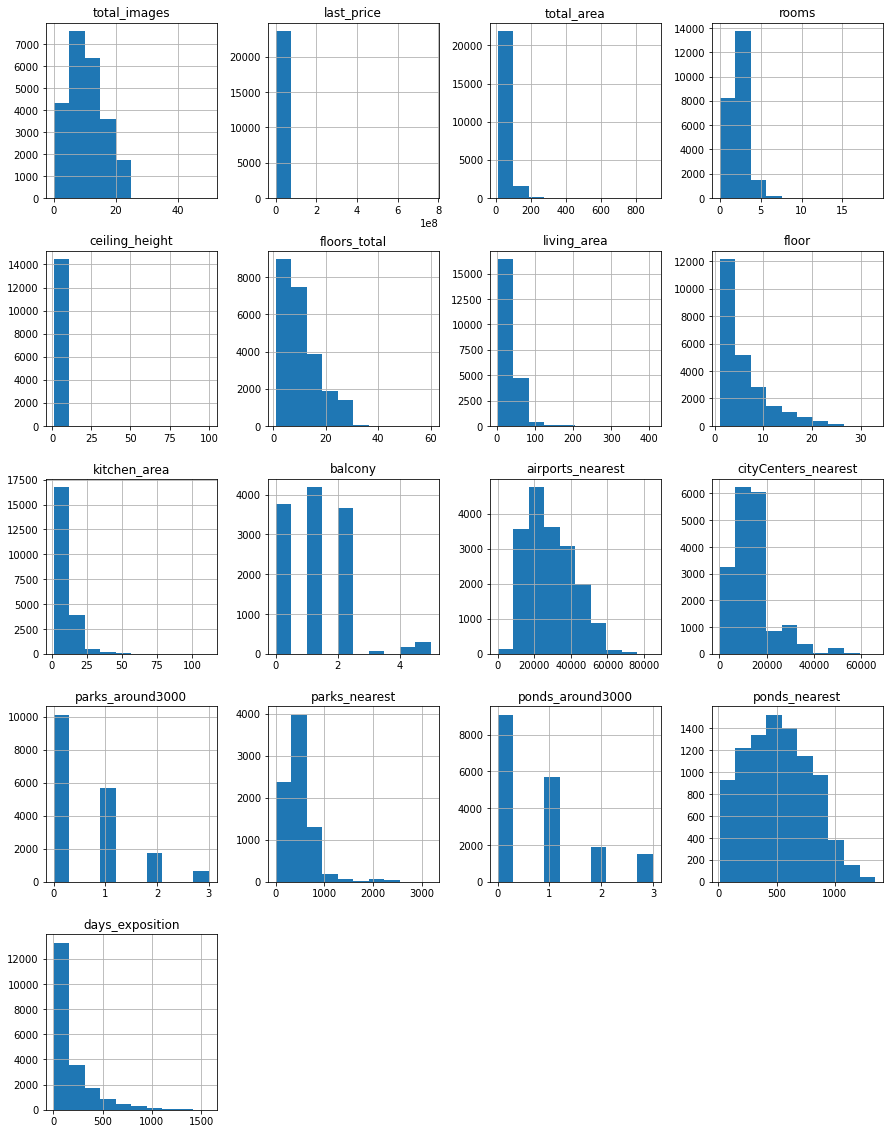

In [17]:
import pandas as pd
import datetime
import numpy as np

df=pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
df.head(20)
df.info()
df.hist(figsize=(15, 20))
df.shape[0]

В таблице 22 столбца:
airports_nearest — расстояние до ближайшего аэропорта в метрах (м)

balcony — число балконов

ceiling_height — высота потолков (м)

cityCenters_nearest — расстояние до центра города (м)

days_exposition — сколько дней было размещено объявление (от публикации до снятия)

first_day_exposition — дата публикации

floor — этаж

floors_total — всего этажей в доме

is_apartment — апартаменты (булев тип)

kitchen_area — площадь кухни в квадратных метрах (м²)

last_price — цена на момент снятия с публикации

living_area — жилая площадь в квадратных метрах(м²)

locality_name — название населённого пункта

open_plan — свободная планировка (булев тип)

parks_around3000 — число парков в радиусе 3 км

parks_nearest — расстояние до ближайшего парка (м)

ponds_around3000 — число водоёмов в радиусе 3 км

ponds_nearest — расстояние до ближайшего водоёма (м)

rooms — число комнат

studio — квартира-студия (булев тип)

total_area — площадь квартиры в квадратных метрах (м²)

total_images — число фотографий квартиры в объявлении


3 столбца содержат логические переменные: is_apartment, open_plan, studio,

1 столбец - качественные переменные: locality_name,

1 столбец содержит дату - first_day_exposition,

все остальные - количественные переменные.


Типы данных следующих столбцов не соответствуют их содержимому:

first_day_exposition - значения в столбце необходимо перевести в формат даты,

floors_total - количество этажей должно быть целым числом,

is_apartment - из описания столбец должен иметь булев тип данных,

balcony - число балконов должно быть целым числом,

parks_around3000 - количество парков заменим на целые числа,

ponds_around3000 - количество водоемов заменим на целые числа.


Копейки в цене квартиры, см в расстояниях до ближайшего парка, аэропорта, центра города нас не интересуют, поэтому в следующих столбцах можно заменить тип данных с вещественного на целочисленный: last_price, airports_nearest, cityCenters_nearest, parks_nearest.


Во многих столбцах таблицы есть отсутствующие значения. Необходимо изучить и обработать эти пропуски.

### Предобработка данных

In [18]:
import warnings

warnings.filterwarnings("ignore")

# пропуски по столбцам
df.isna().sum()

# заполняем пропуски в столбцах 'balcony','parks_around3000','ponds_around3000'
columns_to_replace = ['balcony','parks_around3000','ponds_around3000']
for element in columns_to_replace:
    df[element] = df[element].fillna(value=0)

# заполняем пропуски в столбце 'locality_name'
df['locality_name']=df['locality_name'].fillna(value='без названия')

columns_to_retype = ['balcony', 'parks_around3000', 'ponds_around3000', 'last_price', 'floors_total', 'days_exposition', 'airports_nearest','cityCenters_nearest', 'parks_nearest', 'ponds_nearest']
for vid in columns_to_retype:
    df[vid]=pd.to_numeric(df[vid], downcast='integer',errors='coerce')

# меняем тип данных
df['is_apartment']=df['is_apartment'].astype('bool')

df['first_day_exposition']= pd.to_datetime(df['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S')

# пропуска в 'floors_total'
df = df.dropna(subset=['floors_total'])
for f in df['floors_total'].unique():
    df.loc[(df['floors_total'] == f) & (df['ceiling_height'].isna()), 'ceiling_height'] = df.loc[(df['floors_total'] == f), 'ceiling_height'].median()

# заполняем пропуска медианными значениями
coefficient_living_area = (df['living_area'] / df['total_area']).mean()
df.loc[(df['living_area'].isna()), 'living_area'] = df.loc[(df['living_area'].isna()), 'total_area'] * coefficient_living_area

# замена неявных дубликатов в названиях
df.loc[:,'locality_name']=df.loc[:,'locality_name'].replace('ё','е', regex=True)
df.loc[:,'locality_name']=df.loc[:,'locality_name'].replace('городской','', regex=True)
df.loc[:,'locality_name']=df.loc[:,'locality_name'].replace('городского','', regex=True)
df.loc[:,'locality_name']=df.loc[:,'locality_name'].replace('типа','', regex=True)
df.loc[:,'locality_name']=df.loc[:,'locality_name'].replace('имени','', regex=True)
df.loc[:,'locality_name']=df.loc[:,'locality_name'].replace('станции','', regex=True)
df.loc[:,'locality_name']=df.loc[:,'locality_name'].replace('при железнодорожной','', regex=True)
df.loc[:,'locality_name']=df.loc[:,'locality_name'].replace('садовое товарищество','СНТ', regex=True)
df.loc[:,'locality_name']=df.loc[:,'locality_name'].replace('садововедческое некоммерческое товарищество','СНТ', regex=True)#%% md


Причины приведшие к пропускам: технические ошибки, человеческий фактор.
Пропуск общего количества этажей скорее всего связано со случайным не указанием человека та и наличие или отсутствие балкона. Так же человек может не знать точную высоту потолков. Парки и водоемы могут отсутствовать в радиусе 3 км. ТОчное расстояние до центра, ближайших парков, аэропорта люди возможно не знают. Размер кухни человек то же мог не знать, например кухня совмещена с комнатой, или студия, размер может быть ен вынесен. Пропуски в графе апартаменты и-за неправильного типа в столбце.

Ошибочный тип данных, должен быть int вместо float, потому что целые значения:
last_price - цена на момент снятия с публикации
floors_total — всего этажей в доме
balcony — число балконов
ponds_around3000 — число водоёмов в радиусе 3 км
parks_around3000 — число парков в радиусе 3 км
days_exposition — сколько дней было размещено объявление
parks_nearest — расстояние до ближайшего парка
airports_nearest — расстояние до ближайшего аэропорта
cityCenters_nearest — расстояние до центра города
parks_nearest — расстояние до ближайшего парка
ponds_nearest — расстояние до ближайшего водоёма

first_day_exposition - должен быть типа дата, а не object
is_apartment, studio, open_plan - из object в bool

в строке loc[:,'locality_name']=df.loc[:,'locality_name'].replace('посёлок','поселок', regex=True) заменен на строку df.loc[:,'locality_name']=df.loc[:,'locality_name'].replace('ё','е', regex=True)


living_area 1903 незаполненных строк (8%)

С помощью медианы можно получить более точные данные и правильнее интерпретировать статистику, при использовании средней величны "выбросы" будут искажать данные.

в last_price есть низкая цена 12190
Принял решение не удалять аномалии, а заменить значения цены на среднее в схожих апартаментах

в airports_nearest есть аномальное расстояние 0 м
А количестве этажей аномальное значение у объекта в 60 этажей, сократил в 10 раз значение

In [20]:
col = ['total_images', 'last_price', 'total_area',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor', 'kitchen_area', 'balcony',
       'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition']

for i in col:
    print(df[i].unique())

[20  7 10  0  2  6  5 18  9  1 16 11  8 12 13  3 15 17 14 19 32  4 35 39
 23 21 27 30 24 25 28 31 22 29 26 50 42 37]
[13000000  3350000  5196000 ...  6151120 21400000 11475000]
[108.    40.4   56.   ...  66.86 133.81  76.75]
[ 3  1  2  4  5  6  0  7 11  8 14 10 15  9 19 16 12]
[  2.7    2.75   2.55   2.6    3.03   2.65   2.66   2.5    2.67   2.56
   3.     3.05   2.8    2.9    3.2    2.61   3.25   3.45   2.77   2.85
   2.64   2.57   4.15   3.5    3.3    2.71   4.     2.47   2.73   2.84
   3.1    2.34   3.4    3.06   2.72   2.54   2.51   2.78   2.76  25.
   2.58   3.7   14.85   2.52   5.2    2.87   2.59   2.     2.45   3.6
   2.92   3.11   3.13   3.8    3.15   3.55   3.16   3.62   3.12   2.53
   2.74   2.96   2.46   5.3    5.     2.79   2.95   4.06   2.94   3.82
   3.54   3.53   2.83   4.7    2.4    3.38   3.01   5.6    3.65   3.9
   3.18   3.35   2.3    3.57   2.48   2.62   2.82   3.98   2.63   3.83
   3.52   3.95   3.75   2.88   3.67   3.87   3.66   3.85   3.86   4.19
   3.24   4.8   

In [21]:
df['total_images'].unique() # проверка аномалий фотографий

array([20,  7, 10,  0,  2,  6,  5, 18,  9,  1, 16, 11,  8, 12, 13,  3, 15,
       17, 14, 19, 32,  4, 35, 39, 23, 21, 27, 30, 24, 25, 28, 31, 22, 29,
       26, 50, 42, 37])

In [22]:
sorted(df['ceiling_height'].unique()) #  высота потолков, есть ли аномалии

[1.0,
 1.2,
 1.75,
 2.0,
 2.2,
 2.25,
 2.3,
 2.34,
 2.4,
 2.45,
 2.46,
 2.47,
 2.48,
 2.49,
 2.5,
 2.51,
 2.52,
 2.53,
 2.54,
 2.55,
 2.56,
 2.57,
 2.58,
 2.59,
 2.6,
 2.61,
 2.62,
 2.63,
 2.64,
 2.65,
 2.66,
 2.67,
 2.68,
 2.69,
 2.7,
 2.71,
 2.72,
 2.73,
 2.74,
 2.75,
 2.76,
 2.77,
 2.78,
 2.79,
 2.8,
 2.81,
 2.82,
 2.83,
 2.84,
 2.85,
 2.86,
 2.87,
 2.88,
 2.89,
 2.9,
 2.91,
 2.92,
 2.93,
 2.94,
 2.95,
 2.96,
 2.97,
 2.98,
 2.99,
 3.0,
 3.01,
 3.02,
 3.03,
 3.04,
 3.05,
 3.06,
 3.07,
 3.08,
 3.09,
 3.1,
 3.11,
 3.12,
 3.13,
 3.14,
 3.15,
 3.16,
 3.17,
 3.18,
 3.2,
 3.21,
 3.22,
 3.23,
 3.24,
 3.25,
 3.26,
 3.27,
 3.28,
 3.29,
 3.3,
 3.31,
 3.32,
 3.33,
 3.34,
 3.35,
 3.36,
 3.37,
 3.38,
 3.39,
 3.4,
 3.42,
 3.43,
 3.44,
 3.45,
 3.46,
 3.47,
 3.48,
 3.49,
 3.5,
 3.51,
 3.52,
 3.53,
 3.54,
 3.55,
 3.56,
 3.57,
 3.58,
 3.59,
 3.6,
 3.62,
 3.63,
 3.65,
 3.66,
 3.67,
 3.68,
 3.69,
 3.7,
 3.75,
 3.76,
 3.78,
 3.8,
 3.82,
 3.83,
 3.84,
 3.85,
 3.86,
 3.87,
 3.88,
 3.9,
 3.93,
 3.95,
 3.98,

In [23]:
df.query('ceiling_height>=25') # выявление аномалии если выше 25

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
355,17,3600000,55.2,2018-07-12,2,25.0,5.0,32.0,2,False,...,NaN,2,Гатчина,NaN,NaN,0,NaN,0,NaN,259.0
3148,14,2900000,75.0,2018-11-12,3,32.0,3.0,53.0,2,True,...,8.0,0,Волхов,NaN,NaN,0,NaN,0,NaN,NaN
4643,0,4300000,45.0,2018-02-01,2,25.0,9.0,30.0,2,True,...,7.0,1,Санкт-Петербург,12016.0,13256.0,1,658.0,1,331.0,181.0
4876,7,3000000,25.0,2017-09-27,0,27.0,25.0,17.0,17,True,...,NaN,2,поселок Мурино,NaN,NaN,0,NaN,0,NaN,28.0
5246,0,2500000,54.0,2017-10-13,2,27.0,5.0,30.0,3,True,...,9.0,2,деревня Мины,NaN,NaN,0,NaN,0,NaN,540.0
5669,4,4400000,50.0,2017-08-08,2,26.0,9.0,21.3,3,True,...,7.0,2,Санкт-Петербург,28981.0,10912.0,1,305.0,0,NaN,267.0
5807,17,8150000,80.0,2019-01-09,2,27.0,36.0,41.0,13,True,...,12.0,5,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,38.0
6246,6,3300000,44.4,2019-03-25,2,25.0,5.0,31.3,5,True,...,5.7,0,Кронштадт,68923.0,50649.0,1,417.0,2,73.0,NaN
9379,5,3950000,42.0,2017-03-26,3,25.0,5.0,30.0,2,True,...,5.2,0,Санкт-Петербург,11647.0,13581.0,0,NaN,0,NaN,NaN
10773,8,3800000,58.0,2017-10-13,2,27.0,10.0,30.1,3,False,...,8.1,2,поселок Мурино,NaN,NaN,0,NaN,0,NaN,71.0


In [24]:
df = df[df.ceiling_height > 2] # удаляем строки с аномально низкими потолками (5 шт)
df.loc[(df.ceiling_height >= 10), 'ceiling_height'] = df['ceiling_height']/10
df.drop(labels = [22869],axis = 0,inplace=True) #удаляем строку с высотой потолков 10 м
df.drop(labels = [15061,22309],axis = 0,inplace=True)
df.drop(labels = [397],axis = 0,inplace=True)

In [25]:
df.query('ceiling_height<2') # проверка аномалии если ниже 2 после удаления

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [26]:
sorted(df['kitchen_area'].unique()) # площадь кухни есть ли аномалии

[1.3,
 3.0,
 4.5,
 4.9,
 5.0,
 5.2,
 5.3,
 5.4,
 5.5,
 5.6,
 5.7,
 6.0,
 6.1,
 6.2,
 6.3,
 6.4,
 6.5,
 6.6,
 7.0,
 7.06,
 7.1,
 7.2,
 7.3,
 7.4,
 7.5,
 7.6,
 7.7,
 7.8,
 7.9,
 8.0,
 8.1,
 8.2,
 8.3,
 8.4,
 8.5,
 8.6,
 8.7,
 8.8,
 8.81,
 8.9,
 9.0,
 9.1,
 9.2,
 9.36,
 9.4,
 9.5,
 9.6,
 9.7,
 9.8,
 10.0,
 10.19,
 10.2,
 10.3,
 10.4,
 10.44,
 10.5,
 10.6,
 10.7,
 10.8,
 10.9,
 11.0,
 11.1,
 11.2,
 11.24,
 11.3,
 11.4,
 11.5,
 11.52,
 11.6,
 11.7,
 11.9,
 11.95,
 12.0,
 12.2,
 12.4,
 12.5,
 12.7,
 12.72,
 12.9,
 13.0,
 13.1,
 13.29,
 13.4,
 14.0,
 14.1,
 14.2,
 14.4,
 14.7,
 15.0,
 15.4,
 15.7,
 16.0,
 16.3,
 16.5,
 17.5,
 18.4,
 19.0,
 19.3,
 20.0,
 20.91,
 21.3,
 21.4,
 21.5,
 22.0,
 23.8,
 25.0,
 nan,
 2.0,
 2.3,
 2.4,
 2.89,
 3.2,
 3.3,
 3.4,
 3.5,
 3.7,
 3.8,
 4.0,
 4.1,
 4.2,
 4.3,
 4.4,
 4.6,
 4.7,
 4.8,
 5.04,
 5.06,
 5.1,
 5.14,
 5.21,
 5.23,
 5.25,
 5.28,
 5.29,
 5.31,
 5.33,
 5.35,
 5.42,
 5.44,
 5.47,
 5.49,
 5.53,
 5.59,
 5.61,
 5.62,
 5.64,
 5.65,
 5.68,
 5.74,
 5.75,
 5.78,


In [27]:
df.loc[(df.kitchen_area >= 30), 'kitchen_area'] = df['kitchen_area']/10 # корректируем размер кухни

In [28]:
df.query('(kitchen_area + living_area) >total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
184,7,2600000,30.20,2018-02-14,1,2.65,9.0,26.10,5,True,...,6.20,0,Санкт-Петербург,13952.0,15031.0,0,NaN,1,824.0,12.0
545,9,4700000,23.80,2018-12-28,1,2.70,18.0,20.00,9,True,...,5.00,0,Санкт-Петербург,9731.0,11849.0,0,NaN,0,NaN,108.0
551,8,3100000,31.59,2018-03-08,1,2.70,19.0,30.55,2,True,...,9.28,2,поселок Мурино,NaN,NaN,0,NaN,0,NaN,70.0
601,12,5600000,53.70,2017-04-18,2,2.50,12.0,48.30,5,True,...,7.00,2,Санкт-Петербург,50477.0,13252.0,2,220.0,1,1250.0,167.0
696,1,3364930,34.69,2014-11-27,1,2.64,25.0,23.43,25,True,...,23.43,2,Санкт-Петербург,43396.0,12153.0,0,NaN,0,NaN,574.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21519,8,3950000,55.00,2018-10-28,2,2.60,5.0,52.50,1,False,...,9.00,2,Гатчина,NaN,NaN,0,NaN,0,NaN,58.0
21824,20,2450000,44.00,2019-02-12,2,2.70,2.0,38.00,2,False,...,8.60,2,поселок Большая Ижора,NaN,NaN,0,NaN,0,NaN,NaN
21868,12,2600000,34.30,2018-09-26,1,2.50,9.0,30.60,6,True,...,8.00,2,Сосновый Бор,NaN,NaN,0,NaN,0,NaN,107.0
21956,0,5200000,46.00,2018-07-20,2,2.55,5.0,44.00,5,True,...,8.00,1,Санкт-Петербург,14103.0,15182.0,1,488.0,0,NaN,7.0


In [29]:
df.loc[((df.kitchen_area + df.living_area) > df.total_area), 'kitchen_area'] = \
    df.loc[((df.kitchen_area + df.living_area) > df.total_area), 'total_area'] - df.loc[((df.kitchen_area + df.living_area) > df.total_area), 'living_area']

In [30]:
sorted(df['last_price'].unique()) # аномалия в цене, низкая цена 12190 за двухкомнатные апартаменты

[12190,
 430000,
 440000,
 450000,
 470000,
 480000,
 490000,
 500000,
 520000,
 530000,
 550000,
 560000,
 565000,
 580000,
 585000,
 590000,
 600000,
 620000,
 630000,
 650000,
 660000,
 680000,
 690000,
 700000,
 710000,
 720000,
 730000,
 740000,
 750000,
 760000,
 770000,
 777000,
 780000,
 790000,
 799000,
 800000,
 820000,
 850000,
 860000,
 869000,
 870000,
 880000,
 890000,
 900000,
 910000,
 920000,
 945750,
 950000,
 965780,
 970000,
 980000,
 990000,
 995000,
 999000,
 999999,
 1000000,
 1010000,
 1020000,
 1030000,
 1050000,
 1060000,
 1070000,
 1080000,
 1090000,
 1099000,
 1100000,
 1110000,
 1130000,
 1150000,
 1170000,
 1180000,
 1190000,
 1199000,
 1200000,
 1220000,
 1230000,
 1240000,
 1249000,
 1250000,
 1260000,
 1270000,
 1280000,
 1290000,
 1300000,
 1310000,
 1315000,
 1320000,
 1330000,
 1350000,
 1353000,
 1360000,
 1370000,
 1380000,
 1390000,
 1399000,
 1400000,
 1420000,
 1430000,
 1440000,
 1449900,
 1450000,
 1470000,
 1480000,
 1490000,
 1495000,
 14990

In [31]:
df['last_price'] = np.where((df.last_price <= 20000), 12320263, df.last_price) # замена цены на среднее в максимально схожих
sorted(df['last_price'].unique())

[430000,
 440000,
 450000,
 470000,
 480000,
 490000,
 500000,
 520000,
 530000,
 550000,
 560000,
 565000,
 580000,
 585000,
 590000,
 600000,
 620000,
 630000,
 650000,
 660000,
 680000,
 690000,
 700000,
 710000,
 720000,
 730000,
 740000,
 750000,
 760000,
 770000,
 777000,
 780000,
 790000,
 799000,
 800000,
 820000,
 850000,
 860000,
 869000,
 870000,
 880000,
 890000,
 900000,
 910000,
 920000,
 945750,
 950000,
 965780,
 970000,
 980000,
 990000,
 995000,
 999000,
 999999,
 1000000,
 1010000,
 1020000,
 1030000,
 1050000,
 1060000,
 1070000,
 1080000,
 1090000,
 1099000,
 1100000,
 1110000,
 1130000,
 1150000,
 1170000,
 1180000,
 1190000,
 1199000,
 1200000,
 1220000,
 1230000,
 1240000,
 1249000,
 1250000,
 1260000,
 1270000,
 1280000,
 1290000,
 1300000,
 1310000,
 1315000,
 1320000,
 1330000,
 1350000,
 1353000,
 1360000,
 1370000,
 1380000,
 1390000,
 1399000,
 1400000,
 1420000,
 1430000,
 1440000,
 1449900,
 1450000,
 1470000,
 1480000,
 1490000,
 1495000,
 1499000,
 150

In [32]:
sorted(df['total_area'].unique()) # проверка аномалий общей площади

[12.0,
 13.0,
 13.2,
 14.0,
 15.0,
 15.5,
 16.0,
 17.0,
 17.2,
 17.6,
 17.78,
 18.0,
 18.4,
 18.5,
 18.8,
 18.9,
 19.0,
 19.5,
 20.0,
 20.1,
 20.3,
 20.5,
 20.6,
 20.67,
 20.8,
 21.0,
 21.1,
 21.3,
 21.4,
 21.57,
 21.6,
 21.7,
 21.8,
 21.89,
 21.9,
 22.0,
 22.2,
 22.23,
 22.3,
 22.4,
 22.5,
 22.7,
 23.0,
 23.06,
 23.29,
 23.3,
 23.39,
 23.4,
 23.5,
 23.55,
 23.6,
 23.69,
 23.7,
 23.8,
 23.98,
 24.0,
 24.05,
 24.1,
 24.2,
 24.26,
 24.3,
 24.4,
 24.42,
 24.5,
 24.6,
 24.62,
 24.64,
 24.7,
 24.75,
 24.8,
 24.9,
 25.0,
 25.07,
 25.2,
 25.27,
 25.3,
 25.33,
 25.36,
 25.41,
 25.48,
 25.5,
 25.55,
 25.6,
 25.63,
 25.7,
 25.8,
 25.9,
 26.0,
 26.05,
 26.09,
 26.1,
 26.18,
 26.2,
 26.23,
 26.4,
 26.45,
 26.49,
 26.5,
 26.6,
 26.69,
 26.7,
 26.8,
 26.9,
 27.0,
 27.1,
 27.11,
 27.2,
 27.3,
 27.32,
 27.36,
 27.4,
 27.5,
 27.55,
 27.56,
 27.6,
 27.7,
 27.8,
 27.81,
 27.9,
 28.0,
 28.01,
 28.05,
 28.1,
 28.16,
 28.2,
 28.3,
 28.4,
 28.49,
 28.5,
 28.6,
 28.61,
 28.66,
 28.7,
 28.71,
 28.8,
 28.86,
 2

In [33]:
df.query('floors_total==1')
sorted(df['floors_total'].unique())



[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 34.0,
 35.0,
 36.0,
 52.0,
 60.0]

In [34]:
df.loc[(df.floors_total == 60), 'floors_total'] = df['floors_total']/10 # замена этажей у аномально высокого здания

In [35]:
df = df[df.living_area > 5] # проверка жил площади на аномалии

In [36]:
sorted(df['living_area'].unique()) # поиск аномалий в жилой площади

[5.4,
 6.0,
 6.5,
 7.34432348727348,
 7.457313079385379,
 8.0,
 8.3,
 8.4,
 8.474219408392477,
 8.5,
 8.9,
 9.0,
 9.1,
 9.717104921623374,
 9.8,
 10.0,
 10.08,
 10.169063290070973,
 10.3,
 10.4,
 10.451537270350721,
 10.5,
 10.52,
 10.55,
 10.6,
 10.7,
 10.734011250630472,
 10.76,
 10.8,
 10.9,
 10.93,
 10.94,
 11.0,
 11.1,
 11.15,
 11.2,
 11.29895921118997,
 11.3,
 11.35545400724592,
 11.38,
 11.4,
 11.47,
 11.5,
 11.6,
 11.7,
 11.79,
 11.88,
 11.9,
 11.99,
 12.0,
 12.08,
 12.089886355973267,
 12.1,
 12.18,
 12.2,
 12.28,
 12.3,
 12.315865540197068,
 12.428855132308966,
 12.5,
 12.6,
 12.7,
 12.71,
 12.711329112588716,
 12.79,
 12.8,
 12.81,
 12.9,
 12.993803092868465,
 13.0,
 13.05,
 13.09,
 13.1,
 13.15,
 13.2,
 13.27,
 13.3,
 13.32,
 13.34,
 13.37,
 13.4,
 13.46,
 13.5,
 13.54,
 13.558751053427963,
 13.56,
 13.59,
 13.6,
 13.62,
 13.66,
 13.7,
 13.73,
 13.76,
 13.784730237651761,
 13.8,
 13.82,
 13.89,
 13.9,
 13.92,
 13.954214625819612,
 14.0,
 14.01,
 14.02,
 14.03,
 14.06,
 14.0

In [38]:
df.sort_values(by='days_exposition',ascending=True) # проверка дней до снятия на аномалии

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1632,19,4000000,49.90,2019-05-01,2,2.50,9.0,25.000000,1,True,...,10.00,0,Санкт-Петербург,13567.0,14384.0,1,20.0,1,681.0,1.0
16212,0,7806000,25.00,2019-04-30,1,3.00,5.0,14.123699,5,False,...,NaN,0,Санкт-Петербург,36525.0,10302.0,0,NaN,0,NaN,2.0
16053,4,4070000,45.10,2019-04-30,2,2.55,5.0,22.700000,3,True,...,6.60,0,Санкт-Петербург,40859.0,11668.0,2,485.0,0,NaN,2.0
13061,20,6100000,51.40,2019-04-29,2,3.00,5.0,31.700000,4,True,...,6.90,1,Санкт-Петербург,10776.0,9389.0,0,NaN,0,NaN,2.0
16306,10,4550000,76.50,2018-12-19,3,2.75,25.0,42.000000,8,True,...,9.40,0,Санкт-Петербург,23368.0,4151.0,0,NaN,0,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23684,20,21400000,145.00,2018-11-02,4,3.00,26.0,71.400000,17,True,...,15.60,0,Санкт-Петербург,11827.0,11459.0,0,NaN,0,NaN,NaN
23685,15,2490000,31.00,2019-01-24,1,2.50,5.0,17.300000,5,True,...,5.60,1,Ломоносов,48393.0,51818.0,0,NaN,0,NaN,NaN
23694,9,9700000,133.81,2017-03-21,3,3.70,5.0,73.300000,3,True,...,13.83,0,Санкт-Петербург,24665.0,4232.0,1,796.0,3,381.0,NaN
23696,18,2500000,56.70,2018-02-11,2,2.80,3.0,29.700000,1,True,...,NaN,0,село Рождествено,NaN,NaN,0,NaN,0,NaN,NaN


In [39]:
df.query('airports_nearest<=0 or cityCenters_nearest<=0 or ponds_nearest<=0 or parks_nearest<=0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
21085,0,7000000,34.7,2018-09-23,1,2.7,9.0,19.8,3,True,...,6.0,2,Санкт-Петербург,0.0,22801.0,0,NaN,0,NaN,60.0


In [40]:
df.query('parks_around3000<=0 or ponds_around3000<=0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000,40.40,2018-12-04,1,2.75,11.0,18.600000,1,True,...,11.00,2,поселок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
5,10,2890000,30.40,2018-09-10,1,2.65,12.0,14.400000,5,True,...,9.10,0,поселок Янино-1,NaN,NaN,0,NaN,0,NaN,55.0
6,6,3700000,37.30,2017-11-02,1,2.66,26.0,10.600000,6,True,...,14.40,1,поселок Парголово,52996.0,19143.0,0,NaN,0,NaN,155.0
7,5,7915000,71.60,2019-04-18,2,2.75,24.0,40.450274,22,True,...,18.90,2,Санкт-Петербург,23982.0,11634.0,0,NaN,0,NaN,NaN
8,20,2900000,33.16,2018-05-23,1,2.70,27.0,15.430000,26,True,...,8.81,0,поселок Мурино,NaN,NaN,0,NaN,0,NaN,189.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23691,11,9470000,72.90,2016-10-13,2,2.75,25.0,40.300000,7,True,...,10.60,1,Санкт-Петербург,19424.0,4489.0,0,NaN,1,806.0,519.0
23692,2,1350000,30.00,2017-07-07,1,2.55,5.0,17.500000,4,True,...,6.00,0,Тихвин,NaN,NaN,0,NaN,0,NaN,413.0
23695,14,3100000,59.00,2018-01-15,3,2.55,5.0,38.000000,4,True,...,8.50,0,Тосно,NaN,NaN,0,NaN,0,NaN,45.0
23696,18,2500000,56.70,2018-02-11,2,2.80,3.0,29.700000,1,True,...,NaN,0,село Рождествено,NaN,NaN,0,NaN,0,NaN,NaN


In [41]:
df.query('parks_around3000<=0 or ponds_around3000<=0') # проверка аномалий в число водоёмов и расстояние до ближайшего водоёма

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000,40.40,2018-12-04,1,2.75,11.0,18.600000,1,True,...,11.00,2,поселок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
5,10,2890000,30.40,2018-09-10,1,2.65,12.0,14.400000,5,True,...,9.10,0,поселок Янино-1,NaN,NaN,0,NaN,0,NaN,55.0
6,6,3700000,37.30,2017-11-02,1,2.66,26.0,10.600000,6,True,...,14.40,1,поселок Парголово,52996.0,19143.0,0,NaN,0,NaN,155.0
7,5,7915000,71.60,2019-04-18,2,2.75,24.0,40.450274,22,True,...,18.90,2,Санкт-Петербург,23982.0,11634.0,0,NaN,0,NaN,NaN
8,20,2900000,33.16,2018-05-23,1,2.70,27.0,15.430000,26,True,...,8.81,0,поселок Мурино,NaN,NaN,0,NaN,0,NaN,189.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23691,11,9470000,72.90,2016-10-13,2,2.75,25.0,40.300000,7,True,...,10.60,1,Санкт-Петербург,19424.0,4489.0,0,NaN,1,806.0,519.0
23692,2,1350000,30.00,2017-07-07,1,2.55,5.0,17.500000,4,True,...,6.00,0,Тихвин,NaN,NaN,0,NaN,0,NaN,413.0
23695,14,3100000,59.00,2018-01-15,3,2.55,5.0,38.000000,4,True,...,8.50,0,Тосно,NaN,NaN,0,NaN,0,NaN,45.0
23696,18,2500000,56.70,2018-02-11,2,2.80,3.0,29.700000,1,True,...,NaN,0,село Рождествено,NaN,NaN,0,NaN,0,NaN,NaN


In [42]:
df.query('ponds_around3000<=0 and ponds_nearest<=3000') # проверка аномалий в число водоёмов и расстояние до ближайшего водоёма

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [43]:
df.query('rooms<1') # проверка аномалий в комнатах

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
144,1,2450000,27.00,2017-03-30,0,2.75,24.0,15.500000,2,True,...,NaN,2,поселок Мурино,NaN,NaN,0,NaN,0,NaN,181.0
349,4,2320000,25.00,2017-09-27,0,2.60,14.0,17.000000,1,True,...,NaN,0,деревня Кудрово,NaN,NaN,0,NaN,0,NaN,45.0
440,8,2480000,27.11,2018-03-12,0,2.70,17.0,24.750000,4,True,...,NaN,2,Санкт-Петербург,38171.0,15015.0,0,NaN,2,982.0,64.0
508,0,3375000,34.40,2017-03-28,0,2.66,26.0,24.300000,19,True,...,NaN,1,поселок Парголово,53115.0,19292.0,0,NaN,1,593.0,430.0
608,2,1850000,25.00,2019-02-20,0,2.60,10.0,14.123699,7,True,...,NaN,0,поселок Шушары,NaN,NaN,0,NaN,0,NaN,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23210,7,3200000,26.00,2017-09-01,0,2.75,25.0,18.000000,16,True,...,NaN,0,Санкт-Петербург,11405.0,13222.0,0,NaN,1,623.0,14.0
23442,0,2500000,27.70,2017-09-28,0,2.75,24.0,18.000000,4,True,...,NaN,2,поселок Мурино,NaN,NaN,0,NaN,0,NaN,4.0
23554,15,3350000,26.00,2018-09-07,0,2.75,19.0,14.688647,8,True,...,NaN,0,Санкт-Петербург,18090.0,17092.0,0,NaN,2,112.0,31.0
23592,10,1450000,29.00,2017-11-11,0,2.55,9.0,18.000000,8,True,...,NaN,2,Никольское,NaN,NaN,0,NaN,0,NaN,82.0


In [44]:
df['rooms'] = np.where(df.rooms == 0 , 1, df.rooms) # заполняем комнаты в студии
sorted(df['rooms'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 19]

In [45]:
df.query('total_area>500') # проверка аномалий в общая площадь квартиры

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3117,19,140000000,631.0,2019-03-30,7,2.55,5.0,356.482163,5,True,...,6.00,0,Санкт-Петербург,25707.0,4972.0,0,NaN,2,210.0,NaN
4237,1,50000000,517.0,2017-10-14,7,3.00,4.0,332.000000,3,True,...,22.00,0,Санкт-Петербург,22835.0,1847.0,2,477.0,2,540.0,NaN
5358,20,65000000,590.0,2019-02-14,15,3.50,6.0,409.000000,3,True,...,10.00,0,Санкт-Петербург,24447.0,4666.0,1,767.0,0,NaN,14.0
8018,20,84000000,507.0,2015-12-17,5,4.45,7.0,301.500000,7,True,...,4.55,1,Санкт-Петербург,NaN,5735.0,2,110.0,0,NaN,1078.0
12859,20,140000000,631.2,2019-04-09,7,3.90,4.0,322.300000,4,True,...,19.50,1,Санкт-Петербург,25707.0,4972.0,0,NaN,2,210.0,NaN
15651,20,300000000,618.0,2017-12-18,7,3.40,7.0,258.000000,5,True,...,7.00,0,Санкт-Петербург,32440.0,5297.0,0,NaN,2,198.0,111.0
19540,8,420000000,900.0,2017-12-06,12,2.80,25.0,409.700000,25,True,...,11.20,0,Санкт-Петербург,30706.0,7877.0,0,NaN,2,318.0,106.0


In [46]:
df.drop(labels = [19540],axis = 0,inplace=True) #удаляем строку с выбросом по площади (900м^2)

In [47]:
df.drop(labels = [19392],axis = 0,inplace=True) #удаляем строку без информации о комнатах и площади кухни, площадь слишком большая для студии, ничего не сделать
df.drop(labels = [14498,18848],axis = 0,inplace=True) #удаляем строки с выбросом по комнатам (16 и 19 слишком много)
df.drop(labels = [12971],axis = 0,inplace=True) #удаляем строку с выбросом по цене (763 млн ту мач)

In [48]:
df.shape[0]

23584

### Посчитайте и добавьте в таблицу новые столбцы

In [49]:
df['m2_price']=df['last_price']/df['total_area'] #цена одного квадратного метра
df['day_of_week_exposition']= df['first_day_exposition'].dt.weekday #день недели публикации
df['month_exposition']=df['first_day_exposition'].dt.month #месяц публикации
df['year_exposition']=df['first_day_exposition'].dt.year # год публикации

def fl(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
df['floor_type'] = df.apply(fl, axis=1) #тип этажа
df['cityCenters_km']=round(df['cityCenters_nearest']/1000) # расстояние до центра города в км

### Проведите исследовательский анализ данных

count    2.358400e+04
mean     6.486132e+06
std      9.332317e+06
min      4.300000e+05
25%      3.407500e+06
50%      4.650000e+06
75%      6.799000e+06
max      4.013000e+08
Name: last_price, dtype: float64
count    23584.000000
mean        60.265490
std         35.024156
min         12.000000
25%         40.000000
50%         52.000000
75%         69.800000
max        631.200000
Name: total_area, dtype: float64
count    23584.000000
mean         2.077849
std          1.054530
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         15.000000
Name: rooms, dtype: float64
count    23584.000000
mean         2.709000
std          0.244963
min          2.000000
25%          2.550000
50%          2.650000
75%          2.750000
max          8.300000
Name: ceiling_height, dtype: float64
count    23584.000000
mean        10.668377
std          6.583557
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max        

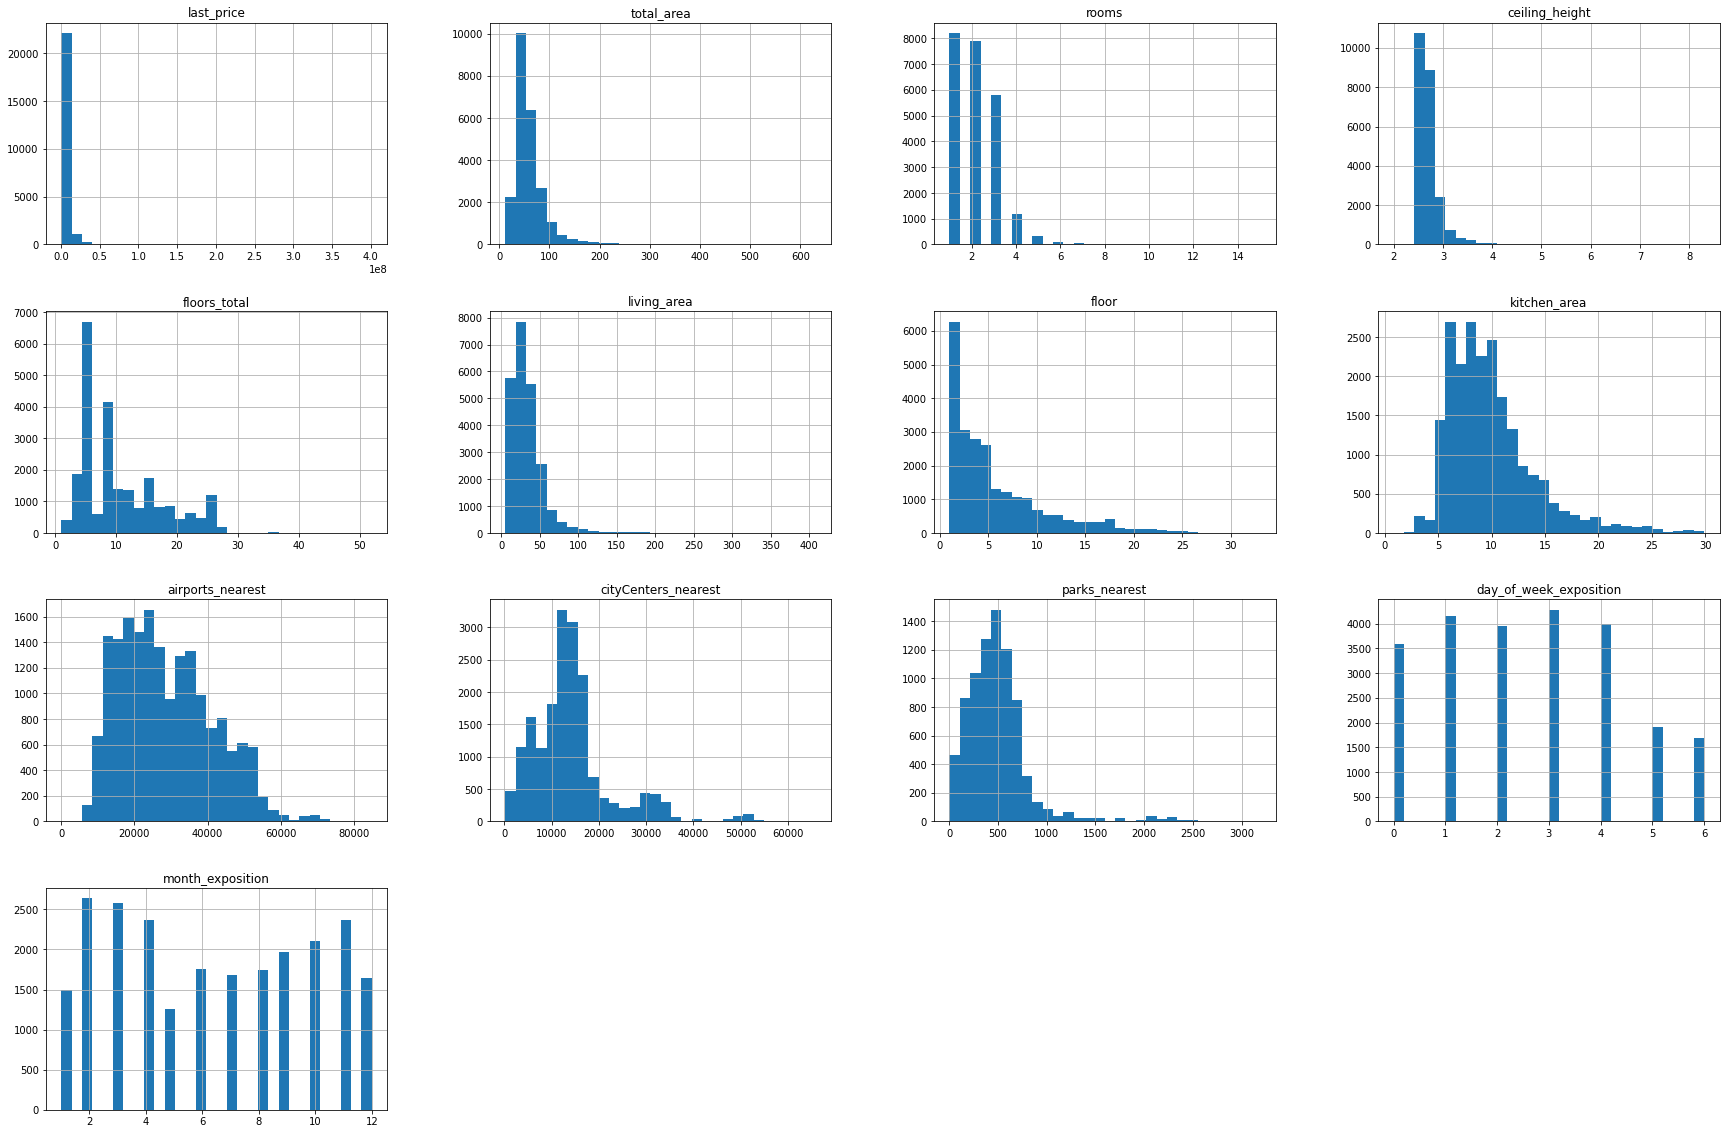

In [50]:
df2 = df[['last_price','total_area',
          'rooms','ceiling_height','floors_total', 'living_area', 'floor', 'kitchen_area',
          'airports_nearest', 'cityCenters_nearest', 'floor_type', 'parks_nearest',
          'day_of_week_exposition', 'month_exposition']]

df2.hist(bins=30,figsize=(30, 20))

for st in df2:
    print(df[st].describe()) #краткий анализ данных

total_area: видно, что среднее значение общей площади находиться в районе 60, основные предложения с площадью 50 - 60 кв. м, меньше до 50 кв., а более 200 кв. м единицы

living_area: среднее значение жилой площади около 35, а так же заметна концентрация значений в коридоре 20 -30, равное количество объектов с жилой площадью от 30 до 40 и 20 кв. м

kitchen_area: в данных площади кухни очень сильный разброс показателей и на графике заметны несколько пиков: 6-7 кв. м, 8 и 10. Средний показатель около 10, а максимальный 30.

rooms: больше всего на графике выделяются однокомнатные и двухкомнатные квартиры, их практически равное количество при среднем значении 2. Почти 6000 объектов имеют 3 комнаты.

ceiling_height: по графику видим, что основная масса значений высоты потолков в коридоре 2,6-2,8. Максимальная высота зафиксирована в районе 8,3м.

floor: большинство объектов расположены до 6 этажа, также на графике заметна скученность значений около 6-9. Максимум здесь 33, а среднее значение  5 - 6.

floors_total : общее количество этажей в зданиях в 5 или 9, что ожидаемо больше всего, а четырехэтажных примерно столько же, сколько 17-этажных. Самый высокий объект 52 этажа.

cityCenters_nearest: расстояние до центра города в метрах имеет коридор 12-15 км, что является наибольшим значением на графике, прослеживается пик в районе 5 км. Объектов с показателем более 38км очень мало.

airports_nearest: расстояние до ближайшего аэропорта на графике наблюдается в широком коридоре 16-23 км, среднее значение хоть и находится в районе 29 км, график показывает, что на отметке 30 имеется провал чуть ниже показателей 39 км. Более 57км имеет малое количество объектов.

parks_nearest: расстояние до ближайшего парка имеют больше всего объектов с показателем 500м (среднее значение тоже в районе данной отметки), меньше всего объектов с дистанцией до парка более 1 км.

days_exposition и month_exposition: больше всего объявлений появляются во вторник и четверг, меньше всего в выходные. Весной наблюдаются пики по публикациям, объемы которых падают к маю, и прослеживается положительная динамика публикаций с конца весны по декабрь.


<AxesSubplot:>

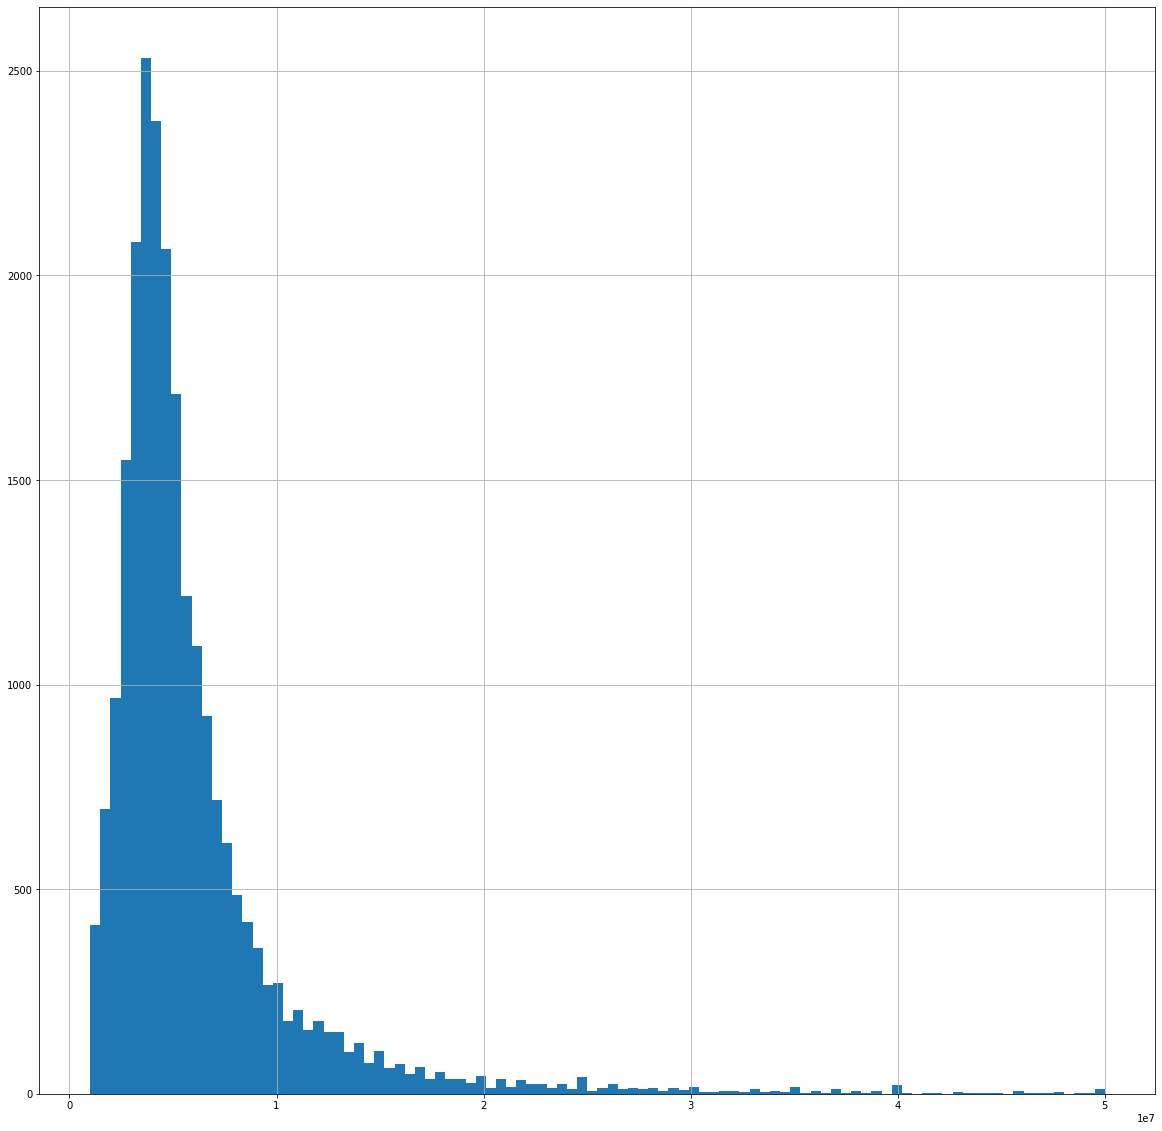

In [51]:
df['last_price'].hist(range = (1000000,50000000),bins=100,figsize=(20, 20)) # более детальный график для цены

last_price : наиболее распространенная цена объекта до 5 млн при средней в 6,5. Цена самого дорогого объекта 401 млн а дешевого - 430000.

<AxesSubplot:>

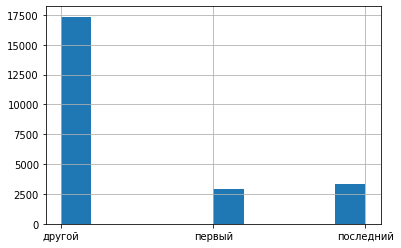

In [52]:
df['floor_type'].hist() # детальный график для типа этажа

floor_type: на последнем и первом этаже примерно поровну объектов - около 2500. Остальные расположены на других этажах.

Среднее значение: 180.91187852069558
Медиана: 95.0


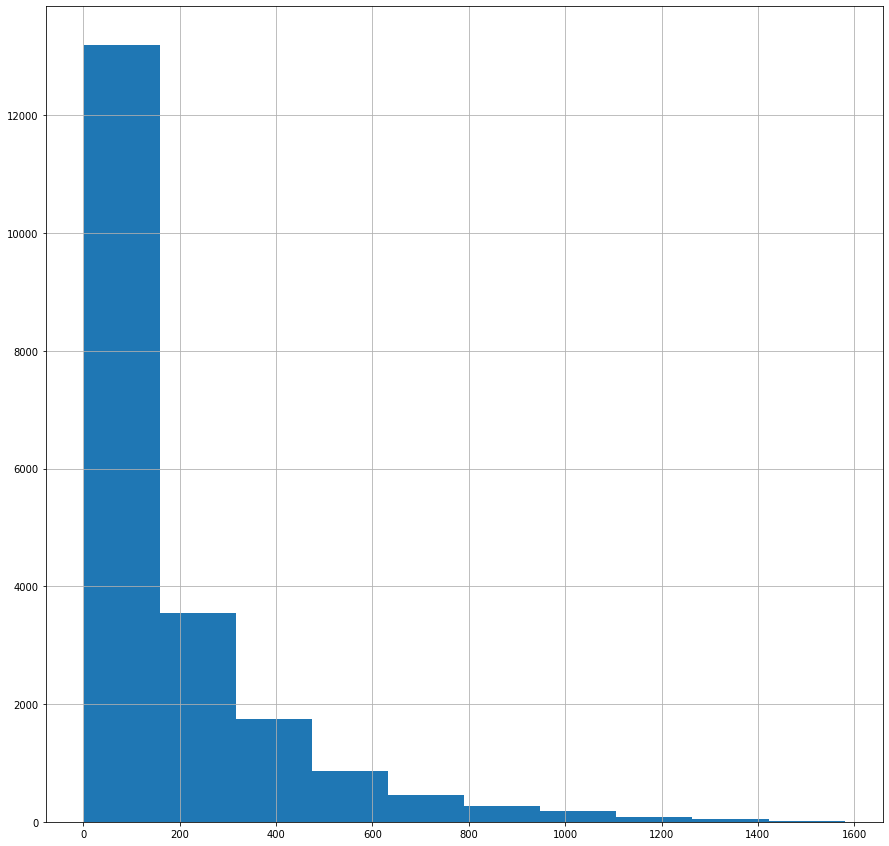

In [53]:
#как быстро продавались квартиры (столбец days_exposition).
df['days_exposition'].hist(figsize=(15, 15))
de_mean=df['days_exposition'].mean()
de_med=df['days_exposition'].median()
print(f'Среднее значение: {de_mean}')
print(f'Медиана: {de_med}')

Объект удается продать в пределах года, причем быстрая продажа происходит за количество дней, близкое к среднему показателю здесь, то есть менее, чем за 6 месяцев. Необычно долгими можно назвать продажи с периодом от 2-2.5 лет.

                        last_price  total_area  living_area  kitchen_area  \
last_price                1.000000    0.694760     0.623843      0.257886   
total_area                0.694760    1.000000     0.945778      0.394515   
living_area               0.623843    0.945778     1.000000      0.278675   
rooms                     0.394651    0.762263     0.832834      0.178772   
kitchen_area              0.257886    0.394515     0.278675      1.000000   
day_of_week_exposition   -0.002357   -0.006122    -0.005607     -0.011911   
month_exposition         -0.002584    0.003313    -0.001239      0.022977   
year_exposition          -0.047728   -0.080035    -0.072641     -0.052914   

                           rooms  day_of_week_exposition  month_exposition  \
last_price              0.394651               -0.002357         -0.002584   
total_area              0.762263               -0.006122          0.003313   
living_area             0.832834               -0.005607         -0.0012

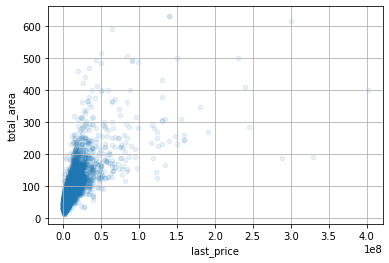

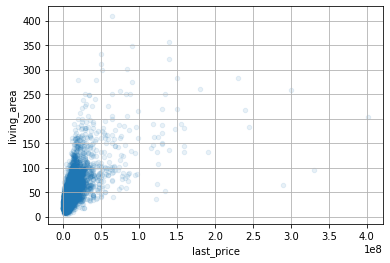

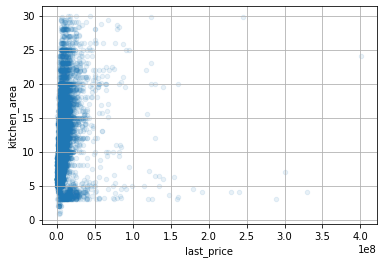

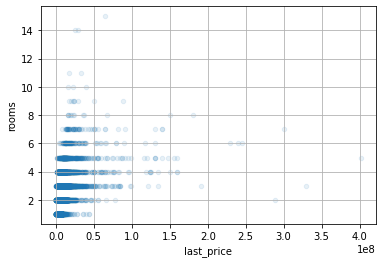

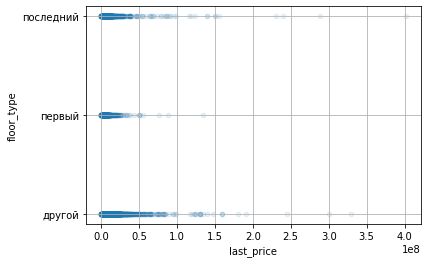

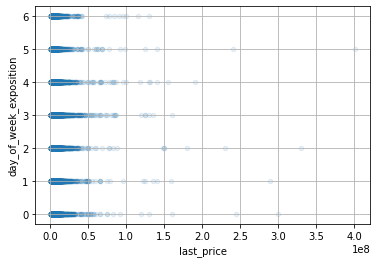

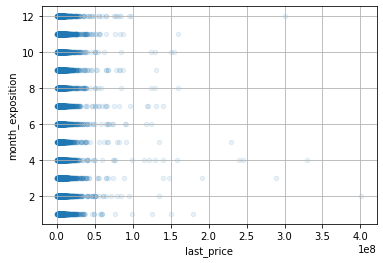

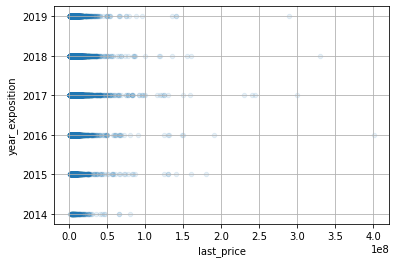

In [54]:
col3=['total_area','living_area','kitchen_area','rooms','floor_type','day_of_week_exposition','month_exposition','year_exposition']

for gu in col3:
    df.plot(x='last_price',y=gu, grid=True,kind='scatter',alpha=0.1) #построение графиков

pr_cor=df[['last_price','total_area','living_area','kitchen_area','rooms','floor_type','day_of_week_exposition','month_exposition','year_exposition']]
print(pr_cor.corr().sort_values(by='last_price',ascending=False)) #матрица корреляции

Зависимость цены от:

Общей площади
Наибольший коэф. корреляции 0.69 означает, что решающее влияние на цену оказывает общая площадь объекта. На графике заметно, что все больше дорогих квартир появляется с ростом общей площади.

Жилой площади
Второй по значимости параметр. График имеет еще больший разброс по цене с ростом жилой площади и можно говорить о положительной тенденции.

Площади кухни
Наименьший, близкий к нулю коэф. корреляции 0.26 из не временных параметров указывает на то, что площадь кухни меньше всего влияет на цену объекта по сравнению с другими не временными показателями. Большинство самых дорогих объектов имеют невысокий показатель площади кухни (до 10 м^2).

Количества комнат
До показателя 5 комнат фиксируем положительный тренд по цене объекта, однако далее тенденция обрывается к самым низким уровням. Это происходит из-за того, что в выборке малое число объектов с количеством комнат более 5. В связи с этим и коэф. корреляции имеет низкое значеие 0.36.

Этажа, на котором расположена квартира (первый, последний, другой)
Объекты на первом этаж имеют меньшую стоимость. Последний этаж также негативно влияет на цену, однако важно учитывать, что большое распределение самых дорогих объектов на других этажах достигнуто, в том числе благодаря меньшинству объектов на крайних этажах в выборке.

Даты размещения (день недели, месяц, год)
Зависимость цены от временных показателей размещения выражена крайне мало. Это подтверждают близкие к нулю коэффициенты корреляции, однако есть две заметные особенности: с 2014 года цены на объекты выросли, по воскресеньям публикуются преимущественно менее дорогие объекты.

In [55]:
local_top=df.pivot_table(index='locality_name', values='m2_price',aggfunc=['count','mean'])
local_top.columns = ['quantity', 'm2_price']
local_top.sort_values(by='quantity',ascending=False).head(10) # средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений
local_top_new=local_top.query('quantity>=129') #сохраняем топ-10
local_top_max=local_top_new[local_top_new['m2_price']==local_top_new['m2_price'].max()]# Найдем строку с максимальным значением
local_top_min=local_top_new[local_top_new['m2_price']==local_top_new['m2_price'].min()]# Найдем строку с минимальным значением
print(local_top_max) # Выведем строку с максимумом на экран
print(local_top_min) # Выведем строку с минимумом на экран
local_top.sort_values(by='quantity',ascending=False).head(10)

                 quantity       m2_price
locality_name                           
Санкт-Петербург     15633  114685.749569
               quantity      m2_price
locality_name                        
Выборг              235  58238.143141


,quantity,m2_price
locality_name,,
Санкт-Петербург,15633,114685.749569
поселок Мурино,551,85601.120803
поселок Шушары,439,78551.344545
Всеволожск,397,68719.320400
Пушкин,369,103125.819291
Колпино,338,75424.579098
поселок Парголово,327,90175.913458
Гатчина,307,68746.146763
деревня Кудрово,299,92473.547576


В Санкт-Петербурге самая высокая цена м^2 - 114685, в то время как в Выборге самая низкая - 58238. В Санкт-Петербурге в десятки раз больше объявлений, чем у преследователей в рейтинге - 15633. В топ-10 по объявлениям замыкает таблицу Выборг с показателем 235.

<AxesSubplot:xlabel='last_price', ylabel='price_km'>

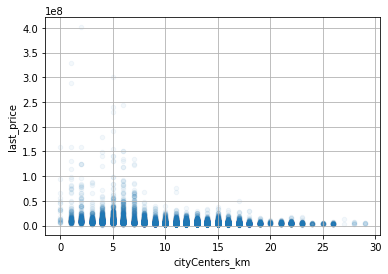

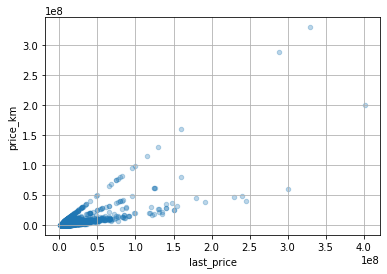

In [56]:
spb=df.copy().query('locality_name=="Санкт-Петербург"') # создаем нужный срез
spb['price_km']=spb['last_price']/spb[ 'cityCenters_km' ]  #создаем столбец с ценой за км
spb.plot(y='last_price',x='cityCenters_km', grid=True,kind='scatter',alpha=0.05) #график зависимости цены от расстояния до центра
spb.plot(x='last_price',y='price_km', grid=True,kind='scatter',alpha=0.3) #график зависимости цены от цены за км

Чем дальше объект от центра, тем его цена ниже, причем самые дорогие объекты удалены от центра города не более, чем на 7-8 км. Примечательно, что в коридоре 10-15 км цены не сильно варьируются.

### Общий вывод

Были выявлены следующие особенности рынка недвижимости в указанном регионе:

Больше всего объектов с общей площадью 50-60 кв. м, жилой площадью 20-30 кв. м, площадью кухни около 10 кв. м, ценой до 6 млн, с 1-2 комнатами, с высотой потолков 2,6-2,8, на этаже 6-9, с расстоянием до центра города 12-15 км, до аэропорта 16-23 км, до парка 500м.

Цена самого дорогого объекта более 400 млн, а дешевого - 430 тыс.

Крайне мало объектов с площадью более 400 кв. м, на этаже выше 30, с дистанцией до парка более 1 км.

Выявлено, что меньше всего объявлений появляются в выходные, во вторник и четверг - больше всего. Весной наблюдаются пики по публикациям, объемы которых падают к маю, и прослеживается положительная динамика публикаций с конца весны по декабрь.

В основном объект удается продать в пределах года. Со временем появляется больше дорогих объектов, как и количество объявлений на ресурсе, особенно с невысокой ценой.

Цена объекта больше всего зависит от общей и жилой площади - зависимость прямая. Меньше всего цена зависит от площади кухни, однако можно отметить, что большинство самых дорогих объектов имеют невысокий показатель площади кухни (до 10 кв. м).

Чем дальше объект от центра, тем его цена ниже, причем самые дорогие объекты удалены от центра города не более, чем на 7-8 км.

Объекты на первом и последнем этажах имеют меньшую стоимость.

Объявлений с числом комнат более 6 меньше всего.

В Санкт-Петербурге самая высокая цена кв. м - 114685, в то время как во Всеволожске самая низкая - 68719. В Санкт-Петербурге в десятки раз больше объявлений, чем у преследователей в рейтинге